In [1]:
import os
import shutil
import platform
import subprocess
import zipfile
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import kaggle
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import trange

Define the paths

In [10]:

kaggle_dir = ".kaggle/"
kaggle_json_path = ".kaggle/kaggle.json"
dataset_url = "danielbacioiu/tig-aluminium-5083"
base_dir = 'kaggle/datasets/al5083/al5083'

Kaggle setup

In [3]:

if not os.path.exists(kaggle_dir):
    os.makedirs(kaggle_dir)

shutil.move(kaggle_json_path, os.path.join(kaggle_dir, "kaggle.json"))

if platform.system() != 'Windows':
    os.chmod(kaggle_json_path, 0o600)
else:
    os.chmod(kaggle_json_path, 0o400)

print("Setup complete!")

Setup complete!


Download dataset

In [4]:

os.chmod(os.path.expanduser(".kaggle/kaggle.json"), 0o600)
subprocess.run(["kaggle", "datasets", "download", "-d", dataset_url])

print("Dataset download complete!")

Dataset download complete!


Unzip dataset

In [6]:

zip_file = None
for file in os.listdir('.'):
    if file.endswith(".zip"):
        zip_file = file
        break

if zip_file:
    zip_file_path = 'tig-aluminium-5083.zip'
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall('kaggle/datasets/')
    print("Dataset unzipped successfully!")
    os.remove(zip_file_path)
    print("Zip archive removed!")
else:
    print("No zip file found.")

Dataset unzipped successfully!
Zip archive removed!


Load and preprocess data

In [11]:
train_data_path = os.path.join(base_dir, 'train')
test_data_path = os.path.join(base_dir, 'test')

Load labels

In [13]:

with open(f'{train_data_path}\\train.json', 'r') as f:
    label_train = json.load(f)

keys_orig = list(label_train.keys())
values = list(label_train.values())
keys = [key.replace("/", " ").split()[0] + ' ' + key.replace("/", " ").split()[1] for key in keys_orig]
true_labels_dict = {keys[i]: values[i] for i in range(len(keys))}

Balance dataset

In [14]:

folders = []
for _, dirnames, _ in os.walk(train_data_path):
    folders.extend(dirnames)
    break

for folder in folders:
    location_files = os.path.join(train_data_path, folder)
    files = []
    for _, _, filenames in os.walk(location_files):
        files.extend(filenames)
        break

    if true_labels_dict[folder] == 0:
        for i, file in enumerate(files):
            if (i + 1) % 8 != 1:
                os.remove(os.path.join(location_files, file))
    elif true_labels_dict[folder] == 1:
        for i, file in enumerate(files):
            if (i + 1) % 2 != 1:
                os.remove(os.path.join(location_files, file))
    elif true_labels_dict[folder] == 2:
        for i, file in enumerate(files):
            if (i + 1) % 7 != 1:
                os.remove(os.path.join(location_files, file))
    elif true_labels_dict[folder] == 3:
        for i, file in enumerate(files):
            if (i + 1) % 4 != 1:
                os.remove(os.path.join(location_files, file))
    elif true_labels_dict[folder] == 4:
        for i, file in enumerate(files):
            if (i + 1) % 3 != 1:
                os.remove(os.path.join(location_files, file))
    elif true_labels_dict[folder] == 5:
        for i, file in enumerate(files):
            if (i + 1) % 3 != 1:
                os.remove(os.path.join(location_files, file))


Load data

In [15]:

mean = 0.2069
std = 0.1471
transform = transforms.Compose([
    transforms.CenterCrop((800, 800)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_dataset = datasets.ImageFolder(root=train_data_path, transform=transform)
original_labels_dict = train_dataset.class_to_idx

Define network

In [16]:

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(3, 8, kernel_size=5, stride=2),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(8, 16, kernel_size=5, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(102400 // 200, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.2),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.1),
            nn.Linear(128, 6),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.reshape(-1, 102400 // 200)
        x = self.classifier(x)
        return x

Training setup

In [17]:
def get_num_correct(pred, label):
    return pred.argmax(dim=1).eq(label).sum().item()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Running on the {'GPU' if device.type == 'cuda' else 'CPU'}")

net = Network().to(device)
label_map_dict = {value: true_labels_dict[key] for key, value in original_labels_dict.items()}

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
optimizer = optim.Adam(net.parameters(), lr=5e-4, weight_decay=1e-3)

Running on the CPU


Train the model

In [21]:
epoch = 0
accuracy_list = []
num_epochs = 10 

with trange(num_epochs, desc="Training Progress") as pbar_epoch:
    while epoch < num_epochs:
        total_loss = 0
        total_correct = 0
        total_length = 0

        with trange(len(train_loader), desc=f"Epoch {epoch+1}", leave=False) as pbar_batch:
            for batch_idx, batch in enumerate(train_loader):
                image, label_original = batch
                label = torch.tensor([label_map_dict[lab.item()] for lab in label_original])

                pred = net(image.to(device))
                loss = F.cross_entropy(pred, label.to(device))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                total_correct += get_num_correct(pred, label.to(device))
                total_length += len(label)

                acc = total_correct * 100 / total_length
                accuracy_list.append(acc)

                pbar_batch.set_postfix({"Loss": loss.item(), "Accuracy": f"{acc:.2f}%"})
                pbar_batch.update()

        epoch_accuracy = total_correct * 100 / total_length
        pbar_epoch.set_postfix({"Epoch Loss": total_loss, "Epoch Accuracy": f"{epoch_accuracy:.2f}%"})
        pbar_epoch.update()

        epoch += 1

        # if epoch_accuracy >= 95:
        #     break


Training Progress: 100%|██████████| 10/10 [56:00<00:00, 336.03s/it, Epoch Loss=620, Epoch Accuracy=98.54%]


Evaluate on test set

In [22]:
# Load test data
test_data_path = os.path.join(base_dir, 'test')
test_dataset = datasets.ImageFolder(root=test_data_path, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

# Evaluation function to identify defective parts
def identify_defective_parts(model, test_loader, device, threshold=0.5):
    model.eval()  # Set model to evaluation mode
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():  # Disable gradient calculation
        for images, labels in test_loader:
            predictions = model(images.to(device))
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    all_predictions = np.array(all_predictions)
    
    # Assuming the defect class is the one with the highest probability
    # Here we assume that the highest probability in the prediction vector indicates the defect
    defect_probabilities = np.max(all_predictions, axis=1)
    
    defective_indices = np.where(defect_probabilities > threshold)[0]
    non_defective_indices = np.where(defect_probabilities <= threshold)[0]
    
    print(f"Defective parts indices: {defective_indices}")
    print(f"Non-defective parts indices: {non_defective_indices}")
    
    return defective_indices, non_defective_indices

# Call the function
defective_indices, non_defective_indices = identify_defective_parts(net, test_loader, device)

Defective parts indices: [   0    1    2 ... 6585 6586 6587]
Non-defective parts indices: [  43  112  129  131  132  133  135  138  140  148  149  152  193  223
  234  238  241  243  245  246  275  498  532  551  610 1031 1035 1489
 1977 3192 3195 3196 3205 3450 3453 3590 3699 3727 3854 3871 3882 3894
 3901 4216 4225 4330 4336 5453 5454 5701 5722 5729 5754]


Plotting Accuracy

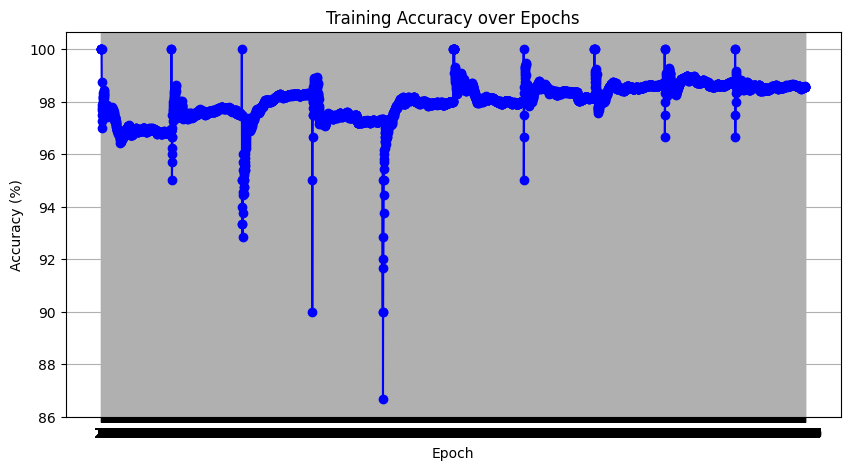

In [23]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(accuracy_list) + 1), accuracy_list, marker='o', linestyle='-', color='b')
plt.title('Training Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.xticks(range(1, len(accuracy_list) + 1))
plt.grid(True)
plt.show()